Neural network for importance sampling supplemented variational inference.

## Motivation

As the visualization of shallow neural network on MNIST dataset shows, the fitting of the PDF of the posterior via variational inference needs further finization. This calls for adding more (trainable) degree of freedom to the inferencer. At the same time, however, we shall keep both the PDF and the sampler of the inference-distribution explicit. Thus, the approach of adding these degree of freedom onto the parameterization of the inference-distribution would be too hard to establish. Instead, we decide to add them onto the weights of the samples sampled from the inference-distribution, thus treat this approach as an importance-sampling.

(Furthermore, the weight is a map from the parameter-space to $\mathbb{R}$, which thus avoids the redundancy of degree of freedom as the approach of neural network sampler (which maps from some low-dimensional hidden space to the high-dimensional parameter-space).)

## Theory

### Loss-function

Let $\theta \in \mathbb{R}^{N_d}$ the parameters, and $p(\theta)$ the PDF of the posterior over the parameter-space. Let $q(\theta; z)$ the inference distribution, with parameter $z$ to be trained. Let
\begin{equation}
  \hat{q}(\theta; z, w) := \omega (\theta; w) q(\theta, z),
\end{equation}
where $\omega (\theta; w)$, mapping to $\mathbb{R}$, is the weights of the importance sampling, with parameter $w$ to be trained.

The loss-function is
\begin{align}
  \mathcal{L} (z, w)
    & := \textrm{KL}(\hat{q} \| p) \\
    & = \int \hat{q} (\theta)
          \left[ \ln \hat{q} (\theta; z, w) - \ln p (\theta) \right]
        d \theta \\
    & = \int q(\theta) \omega (\theta; w)
          \left[ \ln \omega (\theta; w) + \ln q (\theta; z)
                 - \ln p (\theta) \right]
        d \theta \\
    & = \mathbb{E}_{\theta_s \sim q(z)}
          \left\{ \omega (\theta_s; w)
            \left[ \ln \omega (\theta_s; w) + \ln q (\theta_s; z)
                   - \ln p (\theta_s) \right] \right\},
\end{align}
where $s = 1, \ldots, N_s$. Further, for $\theta \in \{\theta_1, \ldots, \theta_{N_s}\} \sim q(z)$, let
\begin{equation}
  \omega(\theta; w) := \textrm{softmax} \left( \zeta (\theta; w) \right) * N_s,
\end{equation}
the normalization of $\hat{q}(\theta; z, w)$ can always be ensured:
\begin{align}
  1 & = \int \hat{q}(\theta; z, w) d\theta \\
    & = \mathbb{E}_{\theta_s \sim q(z)} \left[ \omega (\theta; w) \right] \\
    & = N_s * \mathbb{E}_{\theta_s \sim q(z)}
                \left[ \textrm{softmax} \left( \zeta (\theta; w) \right) \right] \\
    & = N_s * \frac{1}{N_s}
        \sum_s \textrm{softmax}_s \left( \zeta (\theta; w) \right) \\
    & = N_s \frac{1}{N_s} \times 1.
\end{align}

This methods extends the representability of pure variational inference by adding a weight-function. This weight-function can be implemented by a neural network by the utility of its universality.

We do not prefer a large variance of the weights, thus a penalty on this variance in the loss is called for. Thus
\begin{align}
  \mathcal{L}(z, w)
    & \to \mathcal{L}(z, w; \sigma) \\
    & = \mathbb{E}_{\theta_s \sim q(z)}
          \left\{ \omega (\theta_s; w)
            \left[ \ln \omega (\theta_s; w) + \ln q (\theta_s; z)
                   - \ln p (\theta_s) \right] \right\} \\
     & + \mathbb{E}_{\theta_s \sim q(z)}
           \left\{ \left(
             \frac{ \omega(\theta_s; w) - 1 }{ \sigma }
             \right)^2 \right\},
\end{align}
where $\sigma$ is a hyper-parameter.

The machine will automatically minimizes this loss by tuning the trainable parameters $(z, w)$, and then find a "harmonic" way of combining the $\omega$ and $q$, so as to represent the target $p(\theta)$.

### Measurement of Performance

The performance of the inference can be measured explicitly. For each sample $\theta$, define error:
\begin{equation}
  \mathcal{E} (\theta; z, w)
    := \ln p(\theta) - \ln q(\theta, z) - \ln \omega(\theta, w).
\end{equation}
If the inference works, we would expect that the $\{\mathcal{E}(\theta_s) \mid s = 1, \ldots, N_s\}$ distributes around the zero-point. With this, we have, $\forall f(\cdot)$,
\begin{equation}
  \mathbb{E}_{\theta \sim p(\theta)} \left[ f(\theta) \right]
    = \mathbb{E}_{\theta \sim q(\theta)} \left[
        \omega(\theta) \exp\{\mathcal{E}(\theta)\} f(\theta) \right].
\end{equation}
The smaller $\{|\mathcal{E}(\theta)| \mid \theta \sim q \}$, the better the performance is.

Thus, this measurement of performance can also help us in fine-tuning the hyper-parameters, like the $\sigma$, or those in the optimization process.

## Implementation

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.contrib.distributions as tfd
from collections import namedtuple
from tensorflow.contrib.layers import xavier_initializer
np.random.seed(1)
tf.set_random_seed(1)

def softplus(x, limit=30):
  if x > limit:
    return x
  else:
    return np.log(1.0 + np.exp(x))

LossInfo = namedtuple('LossInfo',
    ('samples, sample_logits, sample_weights, log_sample_weights,'
     'log_ps, log_qs, kl_divergence, penalty, loss, errors, gvs'))

def make_loss(log_p, inference_dist, logits, logits_scale=1e+2,
              penalty_scale=1e+0, n_samples=10, use_logits=True):
  """
  Args:
    log_p: Callable from tensor of the shape `[n_dims]` to scalar.
    inference_dist: An instance of `tfd.Distribution`.
    logits: Callable from tensor of the shape `[n_samples, n_dims]`
      to tensor of the shape `[n_samples]`.
      * It would be benefit if the output tensor is bounded, such as
        by employing the activation `lambda x: scale * tf.nn.tanh(x)`
        with some postive float `scale`.
    logits_scale: Positive float.
    n_samples: Positive integer.
  Returns:
    An instance of `LossInfo`.
  """
  with tf.name_scope('Samples'):
    # shape `[n_samples, n_dims]`
    samples = inference_dist.sample(n_samples)
  with tf.name_scope('Logits'):
    # shape: `[n_samples]`
    if use_logits:
      sample_logits = logits(samples)
    else:
      sample_logits = tf.zeros([n_samples])
  with tf.name_scope('KLDivergence'):
    # shape: `[n_samples]`
    sample_weights = tf.nn.softmax(sample_logits) * n_samples
    # shape: `[n_samples]`
    log_sample_weights = tf.log(sample_weights)
    # The batch-supplement may not ensured in `log_p`,
    # so we employ `tf.map_fn` for vectorization
    # shape: `[n_samples]`
    log_ps = tf.map_fn(log_p, samples)
    # Notice `tfd.Distribution.log_prob()` is batch-supplemented,
    # shape: `[n_samples]`
    log_qs = inference_dist.log_prob(samples)
    # shape: `[]`
    kl_divergence = tf.reduce_mean(
      sample_weights * (log_sample_weights + log_qs - log_ps),
      axis=0)
  with tf.name_scope('Penalty'):
    # shape: `[]`
    _, sample_logits_std = tf.nn.moments(sample_logits/logits_scale,
                                         axes=[0])
    # shape: `[]`
    penalty = penalty_scale * tf.nn.relu(sample_logits_std - 1.0)
  with tf.name_scope('Loss'):
    # shape: `[]`
    loss = kl_divergence + penalty
  with tf.name_scope('LogEvidence'):
    # shape: `[]`
    log_evidence = (tf.reduce_logsumexp(log_ps - log_qs, axis=0)
                    - tf.log(tf.to_float(n_samples)))
  with tf.name_scope('Errors'):
    # shape: `[n_samples]`
    errors = log_ps - log_qs - log_sample_weights - log_evidence
  return LossInfo(samples, sample_logits, sample_weights, log_sample_weights,
                  log_ps, log_qs, kl_divergence, penalty, loss, errors, None)

## Experiments

In [69]:
def get_inference_dist(n_dims):
  with tf.name_scope('InferenceDistribution'):
    loc = tf.get_variable('loc', [n_dims], 'float32')
    scale = tf.get_variable('scale', [n_dims], 'float32')
    inference_dist = tfd.Independent(
        tfd.NormalWithSoftplusScale(loc, scale))
  return inference_dist

def get_logits(n_hiddens_list, scale):
  def logits(samples):
    """The `logits` argument of `make_loss()`."""
    with tf.name_scope('LogitsNeuralNetwork'):
      hiddens = samples
      for n_hiddens in n_hiddens_list:
        hiddens = tf.layers.dense(
            hiddens, n_hiddens, activation=tf.nn.sigmoid,
            kernel_initializer=xavier_initializer())
        # Dropping out demages the representability of the ANN.
        #hiddens = tf.layers.dropout(hiddens)  # thus shall not use.
      # shape: `[n_samples, 1]`
      #outputs = tf.layers.dense(hiddens, 1)
      outputs = scale * tf.layers.dense(
          hiddens, 1, activation=tf.tanh,
          kernel_initializer=xavier_initializer())
      # shape: `[n_samples]`
      return tf.squeeze(outputs, axis=1)
  return logits

def test(log_p, n_dims, n_hiddens_list=None, use_logits=True,
         logits_scale=1e+2, penalty_scale=1e+0, lr=1e-3, n_iters=10**4,
         max_trails=2, error_threshold=5, scale=1e+1):
  if n_hiddens_list is None:
    n_hiddens_list = []
  inference_dist = get_inference_dist(n_dims)
  logits = get_logits(n_hiddens_list, scale)
  loss_info = make_loss(log_p, inference_dist, logits,
                        logits_scale, penalty_scale,
                        use_logits=use_logits)
  optimizer = tf.train.RMSPropOptimizer(learning_rate=lr)
  gvs = optimizer.compute_gradients(
      loss_info.loss, tf.trainable_variables())
  #gvs = [(tf.clip_by_value(g, -5., 5.), v) for g, v in gvs]  # clip.
  train_op = optimizer.apply_gradients(gvs)
  sess = tf.Session()
  sess.run(tf.global_variables_initializer())

  print('Loss (before):', sess.run(loss_info.loss))
  print('Penalty (before):', sess.run(loss_info.penalty))

  loss_vals = []
  for step in range(1, n_iters+1):
    sess.run(train_op)

    # The value of loss can sometimes temporally be `NaN`, and in
    # the next `sess.run()` becomes non-`NaN` (strange!). So, we
    # employ the following strategy:
    loss_val = sess.run(loss_info.loss)
    n_trials = 0
    while np.isnan(loss_val) and n_trials < max_trails:
      loss_val = sess.run(loss_info.loss)
      n_trials += 1
    if n_trials == max_trails:
      print(sess.run([loss_info.log_sample_weights, loss_info.log_ps,
                      loss_info.log_qs, loss_info.kl_divergence,
                      loss_info.penalty]))
      print('Always `NaN`, finally stopped at step {}.'.format(step))
      sess.close()
      return
    loss_vals.append(loss_val)

  print('Loss (after):', sess.run(loss_info.loss))
  print('Penalty (after):', sess.run(loss_info.penalty))
  visualize(loss_vals, loss_info, sess, error_threshold)
  sess.close()

def visualize(loss_vals, loss_info, sess,
              error_threshold):
  samples = []
  log_sample_weights = []
  logits = []
  errors = []
  for i in range(100):
    result = sess.run([loss_info.samples, loss_info.log_sample_weights,
                       loss_info.sample_logits, loss_info.errors])
    sample_vals, log_sample_weight_vals, logit_vals, error_vals = result
    samples += [_ for _ in sample_vals]
    log_sample_weights += [_ for _ in log_sample_weight_vals]
    logits += [_ for _ in logit_vals]
    errors += [_ for _ in error_vals]
  samples = np.array(samples)
  log_sample_weights = np.array(log_sample_weights)
  logits = np.array(logits)

  #err_mean = np.mean(errors)
  #err_std = np.std(errors)
  #errors = np.array([_ for _ in errors if abs(_ - err_mean) < 3*err_std])
  errors = np.array(errors)

  # Visualize
  fig = plt.figure()

  ax1 = fig.add_subplot(222)
  ax1.plot(loss_vals, label='loss')
  ax1.legend()

  ax2 = fig.add_subplot(221)
  ax3 = fig.add_subplot(223)
  ax4 = fig.add_subplot(224)
  count = 0
  for l, e, lw, s in zip(
      logits, errors, log_sample_weights, samples[:,0]):
    if abs(e) < error_threshold:
      count += 1
      ax2.scatter(e, l, c='blue', alpha=0.2)
      ax3.scatter(e, lw, c='blue', alpha=0.2)
      ax4.scatter(s, lw, c='blue', alpha=0.2)
  ax2.set_xlabel('$\mathcal{E}$')
  ax2.set_ylabel('logits')
  ax3.set_ylabel('$\ln \omega$')
  ax4.set_xlabel('$\\theta^{\\alpha=0}$')
  print('{} important samples'.format(count))
  print('Importance ratio:', count / len(log_sample_weights))

  plt.show()

### High-dimensional Gaussian distribution

The target is the PDF of distribution
$\mathcal{N} \left(0, \textrm{softplus}(10)\right)$
on $\mathbb{R}^{N_d}$.

In [4]:
def get_log_p(n_dims):
  target_dist = tfd.Independent(
      tfd.NormalWithSoftplusScale(loc=tf.zeros(n_dims),
                                  scale=10*tf.ones(n_dims)))
  return target_dist.log_prob

In [5]:
tf.reset_default_graph()

n_dims = 10000
log_p = get_log_p(n_dims)
kwargs = {
  'use_logits': True,
  'lr': 1e-3,
  'n_hiddens_list': [10, 10, 10],
  'n_iters': 20000,
  'error_threshold': 5,
  'scale': 10,
}
print('PARAMETERS:', kwargs, '\n')
test(log_p, n_dims, **kwargs)

* Conclusion: so far so good.

### More Complex Distribution

In [80]:
def get_log_p(n_dims):
  dist = tfd.Independent(tfd.Gamma(1.2*tf.ones([n_dims]),
                                   1.0*tf.ones([n_dims])))
  def log_p(x):
    return dist.log_prob(tf.exp(x))
  return log_p

PARAMETERS: {'use_logits': False, 'lr': 0.0001, 'n_iters': 30000, 'error_threshold': 2} 

Loss (before): 3.52202
Penalty (before): 0.0
Loss (after): -10.5919
Penalty (after): 0.0
718 important samples
Importance ratio: 0.718


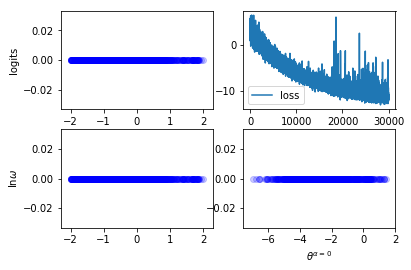

CPU times: user 3min 39s, sys: 4.73 s, total: 3min 44s
Wall time: 2min 58s


In [81]:
%%time

tf.reset_default_graph()

n_dims = 10
log_p = get_log_p(n_dims)
kwargs = {
  'use_logits': False,  # base-line!
  'lr': 1e-4,
  'n_iters': 30000,
  'error_threshold': 2,
}
print('PARAMETERS:', kwargs, '\n')
test(log_p, n_dims, **kwargs)

PARAMETERS: {'use_logits': True, 'lr': 0.0001, 'n_hiddens_list': [10], 'n_iters': 30000, 'error_threshold': 2, 'scale': 10} 

Loss (before): 0.264216
Penalty (before): 0.0
Loss (after): -10.3671
Penalty (after): 0.0
584 important samples
Importance ratio: 0.584


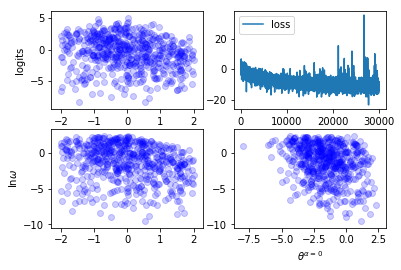

CPU times: user 4min 16s, sys: 7.38 s, total: 4min 24s
Wall time: 3min 27s


In [82]:
%%time

tf.reset_default_graph()

n_dims = 10
log_p = get_log_p(n_dims)
kwargs = {
  'use_logits': True,
  'lr': 1e-4,
  'n_hiddens_list': [10],
  'n_iters': 30000,
  'error_threshold': 2,
  'scale': 10,
}
print('PARAMETERS:', kwargs, '\n')
test(log_p, n_dims, **kwargs)

PARAMETERS: {'use_logits': True, 'lr': 0.0001, 'n_hiddens_list': [10, 10], 'n_iters': 30000, 'error_threshold': 2, 'scale': 10} 

Loss (before): -0.167085
Penalty (before): 0.0
Loss (after): -10.9286
Penalty (after): 0.0
655 important samples
Importance ratio: 0.655


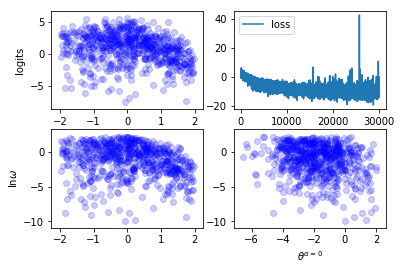

CPU times: user 4min 22s, sys: 7.03 s, total: 4min 29s
Wall time: 3min 33s


In [83]:
%%time

tf.reset_default_graph()

n_dims = 10
log_p = get_log_p(n_dims)
kwargs = {
  'use_logits': True,
  'lr': 1e-4,
  'n_hiddens_list': [10, 10],
  'n_iters': 30000,
  'error_threshold': 2,
  'scale': 10,
}
print('PARAMETERS:', kwargs, '\n')
test(log_p, n_dims, **kwargs)

PARAMETERS: {'use_logits': True, 'lr': 0.0001, 'n_hiddens_list': [100], 'n_iters': 30000, 'error_threshold': 2, 'scale': 10} 

Loss (before): 0.378766
Penalty (before): 0.0
Loss (after): -10.2782
Penalty (after): 0.0
697 important samples
Importance ratio: 0.697


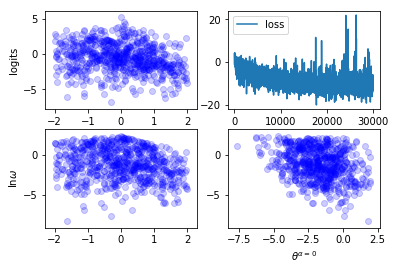

CPU times: user 4min 13s, sys: 6.19 s, total: 4min 19s
Wall time: 3min 27s


In [84]:
%%time

tf.reset_default_graph()

n_dims = 10
log_p = get_log_p(n_dims)
kwargs = {
  'use_logits': True,
  'lr': 1e-4,
  'n_hiddens_list': [100],
  'n_iters': 30000,
  'error_threshold': 2,
  'scale': 10,
}
print('PARAMETERS:', kwargs, '\n')
test(log_p, n_dims, **kwargs)

PARAMETERS: {'use_logits': True, 'lr': 1e-05, 'n_hiddens_list': [100], 'n_iters': 30000, 'error_threshold': 2, 'scale': 10} 

Loss (before): 2.47212
Penalty (before): 0.0
Loss (after): -3.07699
Penalty (after): 0.0
779 important samples
Importance ratio: 0.779


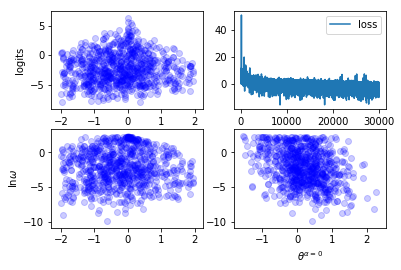

CPU times: user 4min 11s, sys: 5.15 s, total: 4min 16s
Wall time: 3min 29s


In [85]:
%%time

tf.reset_default_graph()

n_dims = 10
log_p = get_log_p(n_dims)
kwargs = {
  'use_logits': True,
  'lr': 1e-5,
  'n_hiddens_list': [100],
  'n_iters': 30000,
  'error_threshold': 2,
  'scale': 10,
}
print('PARAMETERS:', kwargs, '\n')
test(log_p, n_dims, **kwargs)

* Conclusion: XXX